In [1]:
import numpy as np
import torch
from torch import nn
from torch import functional as F
import math

In [2]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [33]:
from livelossplot import PlotLosses

In [3]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
device = 'cpu'

In [5]:
sigma_noise = 0.1
(x_data, y_data) = torch.load('foong_data.pt')
#x_data = x_data.to(device)
#y_data = y_data.to(device)

In [6]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [7]:
def rho_to_sigma(rho):
    sigma = torch.log(1 + torch.exp(rho))
    return sigma

In [8]:
def sigma_to_rho(sigma):
    rho = torch.log(torch.exp(sigma) - 1)
    return rho

In [9]:
class ProbabilisticLinear(nn.Module):
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True):
        super(ProbabilisticLinear, self).__init__()
        self.softplus = torch.nn.Softplus()
        
        self.in_features = in_features
        self.out_features = out_features
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        
        self.weight = torch.Tensor(out_features, in_features)
        self.bias = torch.Tensor(out_features, in_features)
        
        if bias:
            self.bias_mu = nn.Parameter(torch.Tensor(out_features))
            self.bias_rho = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)
        self.reset_parameters()
        
    def generate_rand(self):
        weight_epsilon = torch.randn(size=self.weight_mu.size())
        bias_epsilon = torch.randn(size=self.bias_mu.size())
        return (weight_epsilon, bias_epsilon)
    
    def reparameterization(self, weight_epsilon, bias_epsilon):
        sigma = self.softplus(self.weight_rho)
        weight_sample = weight_epsilon.mul(sigma).add(self.weight_mu)
        sigma = self.softplus(self.bias_rho)
        bias_sample = bias_epsilon.mul(sigma).add(self.bias_mu)
        return (weight_sample, bias_sample)

    def log_pdf(self, weight_sample, bias_sample):
        sigmaw = self.softplus(self.weight_rho)
        nw = torch.distributions.Normal(self.weight_mu, sigmaw)
        sigmab = self.softplus(self.bias_rho)
        nb = torch.distributions.Normal(self.bias_mu, sigmab)
        return nw.log_prob(weight_sample).sum() + nb.log_prob(bias_sample).sum()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight_mu, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weight_rho, a=math.sqrt(5))
        if self.bias_mu is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight_mu)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias_mu, -bound, bound)
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight_rho)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias_rho, -bound, bound)
    
    def set_parameters(self, weight, bias):
        self.weight = weight
        self.bias = bias
    
    def forward(self, input):
        return torch.nn.functional.linear(input, self.weight, self.bias)

    #def extra_repr(self):
    #    return 'in_features={}, out_features={}, bias={}'.format(
    #        self.in_features, self.out_features, self.bias is not None
    #    )

In [83]:
class RegressionModel(nn.Module):
    def __init__(self, H):
        super(RegressionModel, self).__init__()
        
        #The parameters of variation distribution q(w)
        self.q_linear1 = ProbabilisticLinear(1, H)
        self.q_linear2 = ProbabilisticLinear(H,1)
        
        #The prior distribution p(w)
        mu = torch.tensor(0.0)
        rho = sigma_to_rho(torch.tensor(1.0))
        
        self.prior_linear1 = ProbabilisticLinear(1, H)
        nn.init.constant_(self.prior_linear1.weight_mu, mu)
        nn.init.constant_(self.prior_linear1.weight_rho, rho)
        nn.init.constant_(self.prior_linear1.bias_mu, mu)
        nn.init.constant_(self.prior_linear1.bias_rho, rho)
        
        self.prior_linear1.weight_mu.requires_grad = False
        self.prior_linear1.weight_rho.requires_grad = False
        self.prior_linear1.bias_mu.requires_grad = False
        self.prior_linear1.bias_rho.requires_grad = False
        
        self.prior_linear2 = ProbabilisticLinear(H,1)
        nn.init.constant_(self.prior_linear2.weight_mu, mu)
        nn.init.constant_(self.prior_linear2.weight_rho, rho)
        nn.init.constant_(self.prior_linear2.bias_mu, mu)
        nn.init.constant_(self.prior_linear2.bias_rho, rho)
        
        self.prior_linear2.weight_mu.requires_grad = False
        self.prior_linear2.weight_rho.requires_grad = False
        self.prior_linear2.bias_mu.requires_grad = False
        self.prior_linear2.bias_rho.requires_grad = False
        
        self.nb_parameters = self.count_parameters()
        
    def forward(self, x):
        out = torch.tanh(self.q_linear1(x))
        out = self.q_linear2(out)
        return out
        

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
          
    def generate_rand_(self):
        self.q_linear1.weight_epsilon = torch.randn(size=self.q_linear1.weight_mu.size())
        self.q_linear1.bias_epsilon = torch.randn(size=self.q_linear1.bias_mu.size())
        self.q_linear2.weight_epsilon = torch.randn(size=self.q_linear2.weight_mu.size())
        self.q_linear2.bias_epsilon = torch.randn(size=self.q_linear2.bias_mu.size())
    
    def reparam(self):
        sigma = self.softplus(self.q_linear1.weight_rho)
        self.q_linear1.weight_sample = self.q_linear1.weight_epsilon.mul(sigma).add(self.q_linear1.weight_mu)
        sigma = self.softplus(self.q_linear1.bias_rho)
        self.q_linear1.bias_sample = self.q_linear1.bias_epsilon.mul(sigma).add(self.q_linear1.bias_mu)
        sigma = self.softplus(self.q_linear2.weight_rho)
        self.q_linear2.weight_sample = self.q_linear2.weight_epsilon.mul(sigma).add(self.q_linear2.weight_mu)
        sigma = self.softplus(self.q_linear2.bias_rho)
        self.q_linear2.bias_sample = self.q_linear2.bias_epsilon.mul(sigma).add(self.q_linear2.bias_mu)
        
    def compute_elbo(self, x_data, y_data):        
        (q1_weight_epsilon, q1_bias_epsilon) = self.q_linear1.generate_rand()
        (q1_weight_sample, q1_bias_sample) = self.q_linear1.reparameterization(q1_weight_epsilon, q1_bias_epsilon)
        
        (q2_weight_epsilon, q2_bias_epsilon) = self.q_linear2.generate_rand()
        (q2_weight_sample, q2_bias_sample) = self.q_linear2.reparameterization(q2_weight_epsilon, q2_bias_epsilon)
        
        LQ = self.q_linear1.log_pdf(q1_weight_sample, q1_bias_sample) + self.q_linear2.log_pdf(q2_weight_sample, q2_bias_sample)
        
        LP = self.prior_linear1.log_pdf(q1_weight_sample, q1_bias_sample) + self.prior_linear2.log_pdf(q2_weight_sample, q2_bias_sample)
        
        self.q_linear1.set_parameters(q1_weight_sample, q1_bias_sample)
        self.q_linear2.set_parameters(q2_weight_sample, q2_bias_sample)
        y_pred = self.forward(x_data)
        n = torch.distributions.Normal(y_pred, sigma_noise)
        LL = n.log_prob(y_data).sum()
        
        loss = LQ - LP - LL
        
        return loss

In [87]:
model = RegressionModel(50)

In [88]:
learning_rate = 1e-7
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

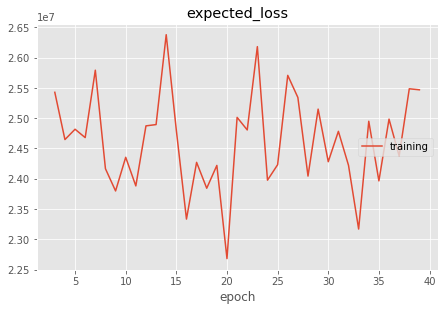

expected_loss:
training   (min: 22680940.000, max: 26378592.000, cur: 25468326.000)


KeyboardInterrupt: 

In [89]:
%matplotlib inline
num_epoch = 100
num_iterations = 1000
liveloss = PlotLosses()

for j in range(num_epoch):
    logs = {}
    losses = [None] * num_iterations
    
    for k in range(num_iterations):
        
        optimizer.zero_grad()
        loss = model.compute_elbo(x_data, y_data)
        losses[k] = loss
    
    logs['expected_loss'] = torch.stack(losses).mean().detach().clone().numpy()
    liveloss.update(logs)
    liveloss.draw()
    
    loss.backward()
    optimizer.step()
    

In [31]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

q_linear1.weight_mu tensor([[-0.9806]])
q_linear1.weight_rho tensor([[0.4877]])
q_linear1.bias_mu tensor([0.9229])
q_linear1.bias_rho tensor([-0.5760])
q_linear2.weight_mu tensor([[-0.9828]])
q_linear2.weight_rho tensor([[-0.0885]])
q_linear2.bias_mu tensor([-0.5145])
q_linear2.bias_rho tensor([-0.7653])


In [24]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

q_linear1.weight_mu tensor([[-0.9807]])
q_linear1.weight_rho tensor([[0.4876]])
q_linear1.bias_mu tensor([0.9230])
q_linear1.bias_rho tensor([-0.5759])
q_linear2.weight_mu tensor([[-0.9829]])
q_linear2.weight_rho tensor([[-0.0884]])
q_linear2.bias_mu tensor([-0.5146])
q_linear2.bias_rho tensor([-0.7654])


In [ ]:
alpha = torch.tensor(10e-5)

In [ ]:
for i in range(0,1000):
    lst_grad_mu = []
    lst_grad_rho = []
    lst_v = []
    for j in range(0,20):
        epsilon = torch.distributions.normal.Normal(torch.tensor(0.0) , torch.tensor(1.0)).sample(torch.Size([2,]))

        with torch.no_grad():
            w = theta[0:2].clone().detach() + torch.log(1 + torch.exp(theta[2:4].clone().detach()))*epsilon
        w.requires_grad = True

        v = f(w, theta)   
        v.backward()
        lst_v.append(v.data)
        v = torch.tensor([])

        with torch.no_grad():
            grad_mu = w.grad + theta.grad[0:2]
            grad_rho = w.grad*epsilon/(1 + torch.exp(-theta[2:4])) + -theta.grad[2:4]


        lst_grad_mu.append(grad_mu)
        lst_grad_rho.append(grad_rho)

        theta.grad.zero_()
        w.grad.zero_()
        v.detach()
    grad_mu = torch.stack(lst_grad_mu).mean(dim=0)
    grad_rho = torch.stack(lst_grad_rho).mean(dim=0)
    
    print(torch.stack(lst_v).mean())
    #print(grad_mu)
    #print(grad_rho)
        
    with torch.no_grad():
        theta[0:2] -= alpha*grad_mu
        theta[2:4] -= alpha*grad_rho
    
    print(theta)
